In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from keras.layers import AveragePooling2D, MaxPooling2D, Concatenate
from keras.layers.core import Flatten, Dense, Dropout
from keras import Model, Input
from keras.optimizers import Adam
from keras.utils import to_categorical
import cv2
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import pickle
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
'''
Load Data
'''

def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 
    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory
    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.jpg'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    pass

In [3]:
'''
Load Data
'''
dir_train_images  = './training_resized/'
dir_test_images   = './validation_resized/'
dir_train_labels  = './labels_training.csv'
dir_test_labels   = './labels_validaton.csv'

X_train, y_train = load_data(dir_train_images, dir_train_labels, training=True)

X_train_rgb = []
for img in X_train:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_train_rgb.append(img_rgb)
X_train_rgb = np.array(X_train_rgb)

X_train_rgb = (X_train_rgb)/255

y_train[y_train==2]=1
y_train[y_train==3]=2
y_train_cat = to_categorical(y_train, num_classes = 3)

In [19]:

'''
split the training dataset into train/validation set
'''

from sklearn.model_selection import train_test_split
X_training, X_test, y_training, y_test = train_test_split(X_train_rgb, y_train_cat, test_size=0.5, random_state=1428)

X_training = X_training.reshape(-1,224,224,3)
X_test = X_test.reshape(-1,224,224,3)

In [5]:
'''
Data preprocessing for test (validation folder)
'''
X_val, y_val = load_data(dir_test_images, dir_test_labels, training=True)
X_val = np.mean(X_val, axis=3)
X_val = X_val.astype(np.uint8)
X_val_rgb = []
for img in X_val:
    img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    X_val_rgb.append(img_rgb)
X_val_rgb = np.array(X_val_rgb)

X_val_rgb = (X_val_rgb)/255


y_val[y_val==2]=1
y_val[y_val==3]=2
y_val_cat = to_categorical(y_val, num_classes = 3)

In [20]:
'''
Pretrained Model
'''

### VGG ###

# vgg_pretrained_model = VGG16(weights="imagenet", 
#                              include_top= False,
#                              input_tensor=Input(shape=(224, 224, 3)))
# new_model = vgg_pretrained_model.output

### ResNet50 ###

resnet50_pretrained = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(224, 224, 3)))

new_model = resnet50_pretrained.output
new_model = AveragePooling2D(pool_size=(3, 3), strides=(2, 2))(new_model)
new_model = Dropout(0.5)(new_model)#4/8 add droup here
new_model = Flatten(name="flatten")(new_model)
#new_model = Dense(12, activation="relu")(new_model)
#new_model = Dropout(0.3)(new_model)
new_model = Dense(3, activation="softmax")(new_model)    

# model = Model(inputs=vgg_pretrained_model.input, outputs=new_model)
model = Model(inputs=resnet50_pretrained.input, outputs=new_model)

In [21]:
'''
Data Augmentation
'''

#from keras.callbacks import EarlyStopping

BS = 8
EPOCHS = 50

opt = Adam(lr=0.0001, decay=0.01 / (EPOCHS))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

class_weight = {0: 1.,
                1: 1.2,
                2: 10.}

aug = ImageDataGenerator(ImageDataGenerator(rotation_range=22.5, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.1, zoom_range=0.2,
                         horizontal_flip=True,vertical_flip =True,  fill_mode="nearest"))

# translation, rotation, horizontal flip, and intensity shift


In [22]:
'''
Model fit
'''
np.random.seed(28)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')
H = model.fit_generator(aug.flow(X_training, y_training, batch_size=BS),
                        validation_data=(X_test, y_test), steps_per_epoch=len(X_training) // BS, epochs=EPOCHS, verbose=1,
                        class_weight = class_weight, callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

C:\programming\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
C:\programming\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
130/130 [==============================] - 35s 273ms/step - loss: 0.7808 - accuracy: 0.8112 - val_loss: 1.0521 - val_accuracy: 0.5125
Epoch 2/50
130/130 [==============================] - 28s 219ms/step - loss: 0.2730 - accuracy: 0.9471 - val_loss: 2.0478 - val_accuracy: 0.5125
Epoch 3/50
130/130 [==============================] - 29s 223ms/step - loss: 0.1579 - accuracy: 0.9600 - val_loss: 1.4193 - val_accuracy: 0.5134
Epoch 4/50
130/130 [==============================] - 29s 219ms/step - loss: 0.1088 - accuracy: 0.9700 - val_loss: 4.0230 - val_accuracy: 0.4290
Epoch 5/50
130/130 [==============================] - 29s 224ms/step - loss: 0.0537 - accuracy: 0.9806 - val_loss: 1.4071 - val_accuracy: 0.4923
Epoch 6/50
130/130 [==============================] - 28s 219ms/step - loss: 0.2740 - accuracy: 0.9622 - val_loss: 3.9497 - val_accuracy: 0.5298

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/50
130/130 [=============================

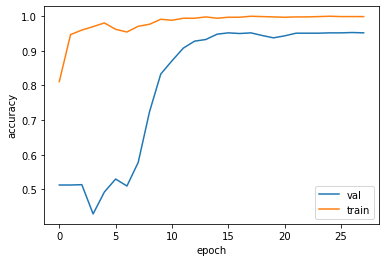

In [23]:
plt.plot(H.history['val_accuracy'], label = "val")
plt.plot(H.history['accuracy'], label = "train")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()

In [24]:
'''
prediction
'''
score = model.predict(np.array(X_test))

y_preds = np.argmax(score, axis=1)
ytest = np.argmax(y_test, axis=1)
print(accuracy_score(ytest, y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(ytest, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9520153550863724


Predicted,0,1,2,All
True,,,,
0,423,18,6,447
1,20,510,4,534
2,0,2,59,61
All,443,530,69,1042


In [25]:
score = model.predict(np.array(X_train_rgb))

y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_train, y_preds))
#confusion_matrix(ytest, y_preds)

pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.9759961593855017


Predicted,0,1,2,All
True,,,,
0,877,18,6,901
1,20,1038,4,1062
2,0,2,118,120
All,897,1058,128,2083


In [ ]:
'''
If predictions is good
'''

# score = model.predict(X_train_rgb)
# np.savetxt("./scores/resnet50_scores.csv", score, delimiter=",")

# y_preds = np.argmax(score, axis=1)

# accuracy_score(y_train.ravel(), y_preds)
# confusion_matrix(y_train.ravel(), y_preds)

# pd.crosstab(y_train, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

In [10]:
'''
save model
'''
filename = 'cnn_1d_do05_avpoolstrid_r50_lr1e4_d001_cwa10a125a100_catetry_moreaug_acc_seed28.sav'
pickle.dump(model, open(filename, 'wb'))
history = "hist_"+filename
pickle.dump(H, open(history, 'wb'))

In [18]:
'''
load model
'''
#filename = 'cnn_r50_aug_lr1e4_cwa01a012a06a10_catetry_nn64to20_moreaug_.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [26]:
'''
prediction
'''
#score = loaded_model.predict(np.array(X_val_rgb))
score = model.predict(np.array(X_val_rgb))
y_preds = np.argmax(score, axis=1)

print(accuracy_score(y_val.ravel(), y_preds))
#print(confusion_matrix(y_val.ravel(), y_preds))

pd.crosstab(y_val, y_preds, rownames=['True'], colnames=['Predicted'], margins=True)

0.868421052631579


Predicted,0,1,2,All
True,,,,
0,449,1,0,450
1,107,402,20,529
2,0,2,7,9
All,556,405,27,988
